In [230]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mizani.formatters import percent_format
import os
from plotnine import *
import numpy as np
import sys
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer import stargazer
from statsmodels.tools.eval_measures import mse,rmse

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from patsy import dmatrices
from sklearn.model_selection import train_test_split

import math

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LinearRegression

In [231]:
# Current script
current_path = os.getcwd()

# Add utils folder to sys path 
sys.path.append(os.path.join(current_path, "utils"))

# Import the prewritten helper functions
from py_helper_functions import *

# Data

In [232]:
# Read the data
data = pd.read_csv("https://raw.githubusercontent.com/00Dabide/DA3-Assignment-2/main/listings.csv")
data.head()

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,38768,https://www.airbnb.com/rooms/38768,20231215032838,2023-12-15,city scrape,Rental unit in Vienna · ★4.75 · 1 bedroom · 3 ...,NaN,the Karmeliterviertel became very popular in t...,https://a0.muscache.com/pictures/ad4089a3-5355...,166283,...,4.94,4.77,4.70,NaN,t,3,3,0,0,2.48
1,40625,https://www.airbnb.com/rooms/40625,20231215032838,2023-12-15,city scrape,Rental unit in Vienna · ★4.85 · 2 bedrooms · 4...,NaN,The neighbourhood offers plenty of restaurants...,https://a0.muscache.com/pictures/11509144/d55c...,175131,...,4.94,4.59,4.72,NaN,t,15,14,1,0,1.24
2,51287,https://www.airbnb.com/rooms/51287,20231215032838,2023-12-15,city scrape,Rental unit in Vienna · ★4.66 · Studio · 2 bed...,NaN,The neighbourhood has a lot of very nice littl...,https://a0.muscache.com/pictures/25163038/1c4e...,166283,...,4.95,4.86,4.59,NaN,f,3,3,0,0,2.36
3,70637,https://www.airbnb.com/rooms/70637,20231215032838,2023-12-15,city scrape,Rental unit in Vienna · ★4.77 · 1 bedroom · 2 ...,NaN,NaN,https://a0.muscache.com/pictures/925691/c8c1bd...,358842,...,4.76,4.81,4.72,NaN,f,3,1,2,0,0.75
4,75500,https://www.airbnb.com/rooms/75500,20231215032838,2023-12-15,city scrape,Rental unit in Vienna · ★4.45 · 2 bedrooms · 2...,NaN,NaN,https://a0.muscache.com/pictures/549090/b51ce4...,400857,...,4.67,4.08,4.42,NaN,f,1,1,0,0,0.08


# Cleaning

In [233]:
# Declare variables that will be used

# basic variables
basic_vars = [
    "accommodates", 
    "beds", 
    "property_type", 
    "room_type", 
    "bathrooms_text",
    "neighbourhood_cleansed", 
]

# reviews
reviews = [
    "number_of_reviews", 
    "flag_number_of_reviews", 
    "review_scores_rating",
    "flag_review_scores_rating",
]

# host dummy variables + instant_bookable dummy
host = [
    "host_is_superhost", 
    "host_has_profile_pic",
    "host_identity_verified",
    "instant_bookable", 
]

# interactions for the LASSO
# from ch14
X1 = [
    "accommodates:property_type", 
    "room_type:property_type", 
    "room_type:instant_bookable",
]
# with boroughs
X2 = [
    "property_type:neighbourhood_cleansed", 
    "room_type:neighbourhood_cleansed",
    "accommodates:neighbourhood_cleansed",
]

predictors_1 = basic_vars
predictors_2 = basic_vars + reviews + host
predictors_E = basic_vars + reviews + host + X1 + X2

In [234]:
# Def "dummifier" functions

# For self-created dummies (True/False)
def todummy(b):
    if b == True:
        return 1
    return 0

# For data dummies (t/f)
def todummy2(b):
    if b == "t":
        return 1
    return 0

In [235]:
# Only 2-6 people accommodations
data = data.loc[data["accommodates"].between(2,6)]


# Exclude Hotel rooms
data = data.loc[data["room_type"] != "Hotel room"]


# Only Rental unit or condo(basically apartment)
data = data[data["property_type"].str.contains("Entire rental unit|Private room in rental unit|Entire condo|Private room in condo") == True]

# Drop rows, where the price is missing (NAN)
data = data.dropna(subset=["price"])


# Replace currency price to float
data["price"] = data["price"].replace('[\$,]', '', regex=True).astype(float)

# Get rid of very high/absurd values
data = data.loc[data["price"] < 350]


#Flags

# Has review (more than 0)
data["flag_number_of_reviews"] = data["number_of_reviews"] > 0

# Has a score of at least 3.5
data["flag_review_scores_rating"] = (data["review_scores_rating"] >= 3.5)


# Replace booleans to 1/0, so the program will be able to use it

data["flag_number_of_reviews"] = data["flag_number_of_reviews"].apply(todummy)
print(data["flag_number_of_reviews"].value_counts())
data["flag_review_scores_rating"] = data["flag_review_scores_rating"].apply(todummy)
print(data["flag_review_scores_rating"].value_counts())


data["host_is_superhost"] = data["host_is_superhost"].apply(todummy2)
print(data["host_is_superhost"].value_counts())
data["host_has_profile_pic"] = data["host_has_profile_pic"].apply(todummy2)
print(data["host_has_profile_pic"].value_counts())
data["host_identity_verified"] = data["host_identity_verified"].apply(todummy2)
print(data["host_identity_verified"].value_counts())
data["instant_bookable"] = data["instant_bookable"].apply(todummy2)
print(data["instant_bookable"].value_counts())


# Check for columns with NA values and drop them
for i in predictors_2:
    if data[i].isna().sum() > 0:
        data = data.dropna(subset=[i])

flag_number_of_reviews
1    8156
0    1270
Name: count, dtype: int64
flag_review_scores_rating
1    8001
0    1425
Name: count, dtype: int64
host_is_superhost
0    6359
1    3067
Name: count, dtype: int64
host_has_profile_pic
1    9064
0     362
Name: count, dtype: int64
host_identity_verified
1    8877
0     549
Name: count, dtype: int64
instant_bookable
1    4985
0    4441
Name: count, dtype: int64


# 3 Different models:
- Linear OLS regression
- Random Forest
- LASSO

In [236]:
#train and test data
data_train, data_holdout = train_test_split(data, train_size=0.7, random_state=42)
data_train.shape, data_holdout.shape

((5607, 77), (2403, 77))

# OLS

In [237]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

ols_model = LinearRegression().fit(X,y)

#y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_2), data_holdout)

y_hat = ols_model.predict(X)

ols_rmse = mean_squared_error(y,y_hat,squared=False)
ols_rmse

41.727361072403575

In [238]:
ols_model_coeffs_df = pd.DataFrame(
    ols_model.coef_.tolist()[0],
    index=X.design_info.column_names,
    columns=["ols_coefficient"],
).assign(ols_coefficient=lambda x: x.ols_coefficient.round(3))

In [239]:
ols_model_coeffs_df

,ols_coefficient
Intercept,-0.000
property_type[T.Entire rental unit],3.589
property_type[T.Private room in condo],-14.891
property_type[T.Private room in rental unit],-10.142
room_type[T.Private room],-25.033
bathrooms_text[T.1 bath],-15.633
bathrooms_text[T.1 private bath],27.045
bathrooms_text[T.1 shared bath],-8.741
bathrooms_text[T.1.5 baths],-7.933
bathrooms_text[T.1.5 shared baths],-6.401


# Random Forest

## RF Model

In [240]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

In [241]:
print('The theoretical recommended number of variables: {:.2f}.'.format(math.sqrt(len(X.design_info.column_names))))

The theoretical recommended number of variables: 7.21.


In [242]:
rfr = RandomForestRegressor(random_state = 20240129)
tune_grid = {"max_features": [6, 8, 10, 12], "min_samples_leaf": [5, 10, 15]}
rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

In [243]:
%%time
rf_model = rf_random.fit(X, y.ravel())

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END max_features=6, min_samples_leaf=5;, score=-41.501 total time=   0.4s
[CV 2/5] END max_features=6, min_samples_leaf=5;, score=-44.980 total time=   0.4s
[CV 3/5] END max_features=6, min_samples_leaf=5;, score=-40.499 total time=   0.4s
[CV 4/5] END max_features=6, min_samples_leaf=5;, score=-39.994 total time=   0.4s
[CV 5/5] END max_features=6, min_samples_leaf=5;, score=-43.077 total time=   0.4s
[CV 1/5] END max_features=6, min_samples_leaf=10;, score=-42.234 total time=   0.3s
[CV 2/5] END max_features=6, min_samples_leaf=10;, score=-45.725 total time=   0.3s
[CV 3/5] END max_features=6, min_samples_leaf=10;, score=-41.523 total time=   0.3s
[CV 4/5] END max_features=6, min_samples_leaf=10;, score=-41.169 total time=   0.3s
[CV 5/5] END max_features=6, min_samples_leaf=10;, score=-43.928 total time=   0.3s
[CV 1/5] END max_features=6, min_samples_leaf=15;, score=-42.764 total time=   0.2s
[CV 2/5] END max_fea

In [244]:
df_rf_model_cv_results = pd.DataFrame(rf_model.cv_results_)[[
    'param_max_features', 'param_min_samples_leaf', 'mean_test_score']]

df_rf_model_cv_results.columns = ['max features', 'min node size', 'RMSE']

df_rf_model_cv_results

,max features,min node size,RMSE
0,6,5,-42.010086
1,6,10,-42.915914
2,6,15,-43.522655
3,8,5,-41.693254
4,8,10,-42.520519
5,8,15,-43.056675
6,10,5,-41.513507
7,10,10,-42.288844
8,10,15,-42.810781
9,12,5,-41.549108


In [245]:
df_rf_model_cv_results.pivot(
    index = 'max features', 
    columns = 'min node size', 
    values = 'RMSE').round(2)*-1

min node size,5,10,15
max features,,,
6,42.01,42.92,43.52
8,41.69,42.52,43.06
10,41.51,42.29,42.81
12,41.55,42.08,42.58


In [246]:
print("Best Score:",rf_model.best_score_)
print("Best Parameters:",rf_model.best_params_)
rf_model.best_estimator_

Best Score: -41.51350671272884
Best Parameters: {'max_features': 10, 'min_samples_leaf': 5}


RandomForestRegressor(max_features=10, min_samples_leaf=5,
                      random_state=20240129)

## Diagnostic: Feature importances

In [247]:
rf_model.best_estimator_.feature_importances_

array([0.00000000e+00, 1.88551685e-02, 5.69857713e-04, 2.92732823e-02,
       5.28761433e-02, 2.33191818e-02, 3.75777740e-03, 1.07816197e-02,
       1.74057678e-02, 1.61591145e-03, 3.29824177e-02, 1.85111858e-04,
       2.82606245e-02, 2.88875984e-05, 0.00000000e+00, 1.08991808e-04,
       0.00000000e+00, 0.00000000e+00, 1.25278401e-04, 0.00000000e+00,
       4.23323193e-03, 3.11377297e-03, 6.05260574e-04, 6.37380291e-03,
       1.83779454e-03, 4.99628745e-03, 4.16038665e-03, 1.60019128e-01,
       1.16023009e-02, 1.66099704e-02, 8.34359521e-03, 2.01297208e-04,
       3.77836909e-03, 6.94248024e-03, 4.65655967e-03, 4.42840402e-03,
       6.37684870e-03, 2.09388693e-03, 1.38792913e-02, 2.54622409e-03,
       1.28342656e-02, 1.72822060e-03, 1.89582438e-01, 6.46651502e-02,
       9.89241071e-02, 0.00000000e+00, 8.70674148e-02, 1.56265028e-03,
       2.55992519e-02, 1.83857690e-03, 2.10616131e-03, 2.71468480e-02])

In [248]:
pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)

,0
Intercept,0.000000
property_type[T.Entire rental unit],0.018855
property_type[T.Private room in condo],0.000570
property_type[T.Private room in rental unit],0.029273
room_type[T.Private room],0.052876
bathrooms_text[T.1 bath],0.023319
bathrooms_text[T.1 private bath],0.003758
bathrooms_text[T.1 shared bath],0.010782
bathrooms_text[T.1.5 baths],0.017406
bathrooms_text[T.1.5 shared baths],0.001616


In [249]:
df_var_imp = pd.DataFrame(
    rf_model.best_estimator_.feature_importances_, 
    X.design_info.column_names)\
    .reset_index()\
    .rename({"index": "variable", 0: "imp"}, axis=1)\
    .sort_values(by=["imp"], ascending=False)\
    .reset_index(drop = True)

df_var_imp['cumulative_imp'] = df_var_imp['imp'].cumsum()

df_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,accommodates,19.0%,19.0%
1,neighbourhood_cleansed[T.Innere Stadt],16.0%,35.0%
2,number_of_reviews,9.9%,44.9%
3,review_scores_rating,8.7%,53.6%
4,beds,6.5%,60.0%
5,room_type[T.Private room],5.3%,65.3%
6,bathrooms_text[T.2 baths],3.3%,68.6%
7,property_type[T.Private room in rental unit],2.9%,71.5%
8,bathrooms_text[T.2.5 baths],2.8%,74.4%
9,instant_bookable,2.7%,77.1%


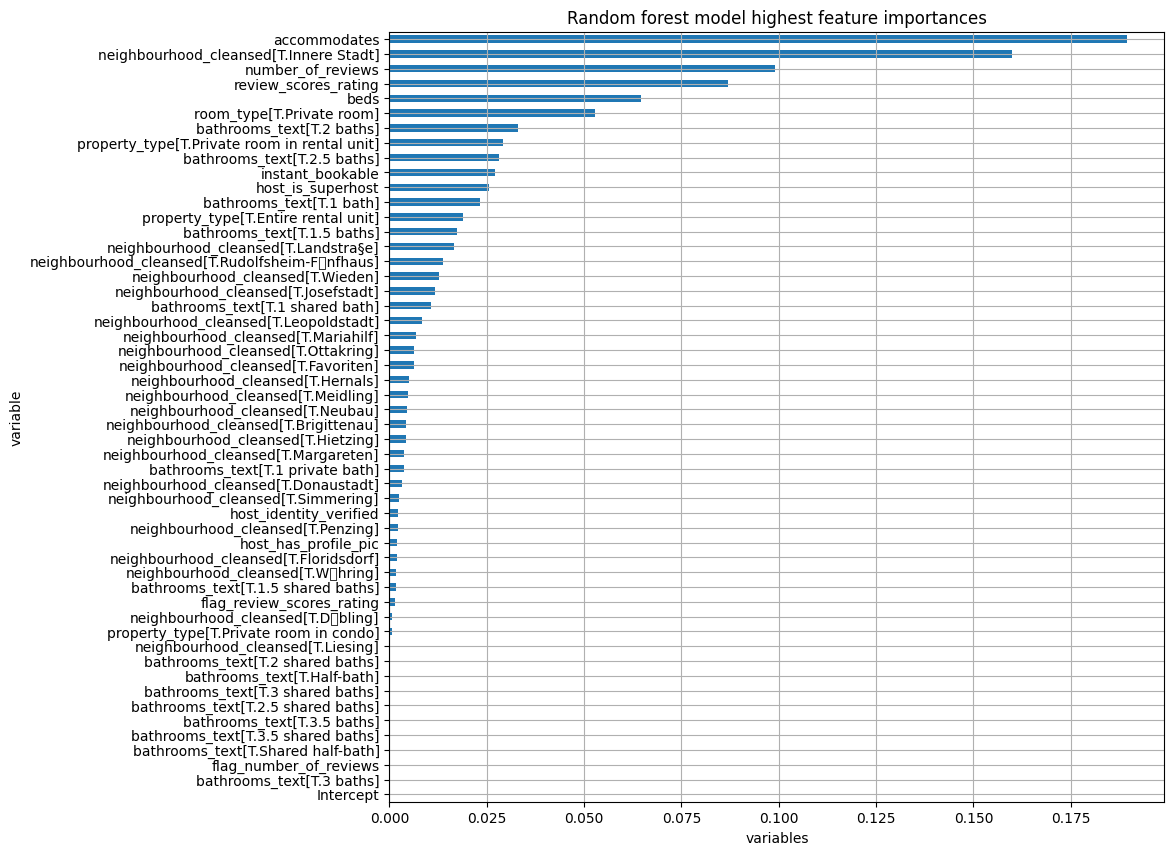

In [250]:
df_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,10), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

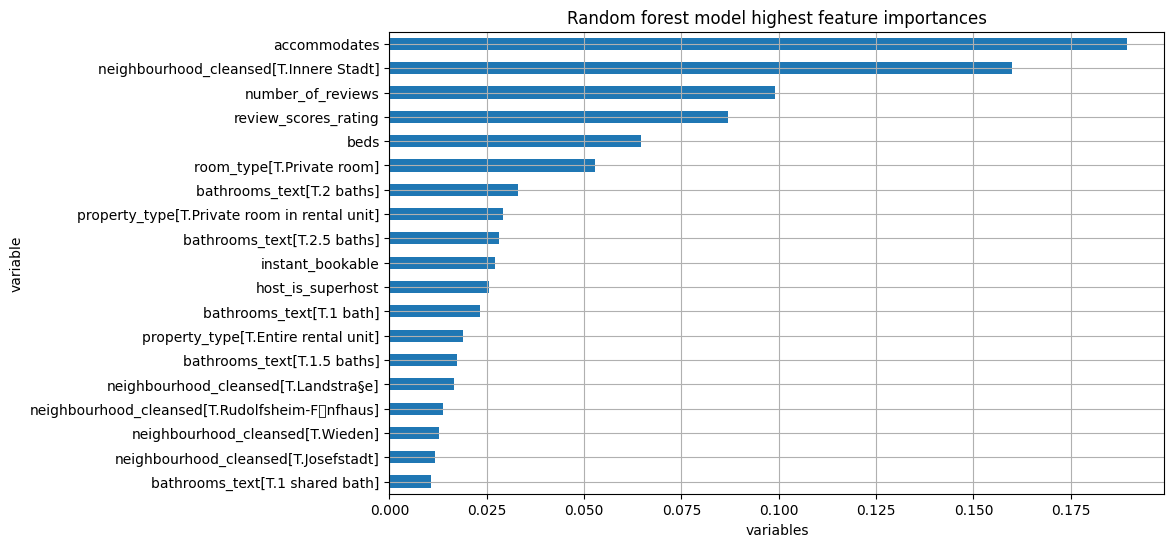

In [251]:
# we only care for variables with an importance of more than 1 pct
cutoff = 0.01

df_var_imp[df_var_imp.imp > cutoff]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model highest feature importances', 
          xlabel = 'variables', legend = False
         );

In [252]:
categorical_columns = [
    "property_type",
    "room_type",
    "bathrooms_text",
    "neighbourhood_cleansed",
]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer([
    ("cat", categorical_encoder, categorical_columns),
    ("num", "passthrough", numerical_columns)])

rf_pipeline = Pipeline(
    [("preprocess", preprocessing), 
     ("regressor", rf_model.best_estimator_)] # put best model to pipeline
)

In [253]:
%%time
rf_pipeline.fit(data_train[predictors_2],data_train.price)

CPU times: total: 2.81 s
Wall time: 2.89 s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['property_type', 'room_type',
                                                   'bathrooms_text',
                                                   'neighbourhood_cleansed']),
                                                 ('num', 'passthrough',
                                                  ['accommodates', 'beds',
                                                   'number_of_reviews',
                                                   'flag_number_of_reviews',
                                                   'review_scores_rating',
                                                   'flag_review_scores_rating',
                                                   'host_is_superhost',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified',
                                                   'instant_bookable'])])),
                ('regressor',
                 RandomForestRegressor(max_features=10, min_samples_leaf=5,
                                       random_state=20240129))])

In [254]:
%%time
result = permutation_importance(
    rf_pipeline,
    data_holdout[predictors_2],
    data_holdout.price,
    n_repeats=10,
    random_state=45,
)

CPU times: total: 6.22 s
Wall time: 6.25 s


In [255]:
pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)

,0
accommodates,0.145854
beds,0.018293
property_type,0.009523
room_type,0.050602
bathrooms_text,0.048252
neighbourhood_cleansed,0.194533
number_of_reviews,0.042814
flag_number_of_reviews,0.000000
review_scores_rating,0.027590
flag_review_scores_rating,-0.000038


In [256]:
grouped = [
    "accommodates",
    "beds",
    "property_type",
    "room_type",
    "bathrooms_text",
    "neighbourhood_cleansed",
]

df_grouped_var_imp = pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)\
    .loc[grouped]\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)
df_grouped_var_imp['cumulative_imp'] = df_grouped_var_imp.imp.cumsum()

df_grouped_var_imp.style.format({
    'imp': lambda x: f'{x:,.1%}',
    'cumulative_imp': lambda x: f'{x:,.1%}'})

,variable,imp,cumulative_imp
0,neighbourhood_cleansed,19.5%,19.5%
1,accommodates,14.6%,34.0%
2,room_type,5.1%,39.1%
3,bathrooms_text,4.8%,43.9%
4,beds,1.8%,45.8%
5,property_type,1.0%,46.7%


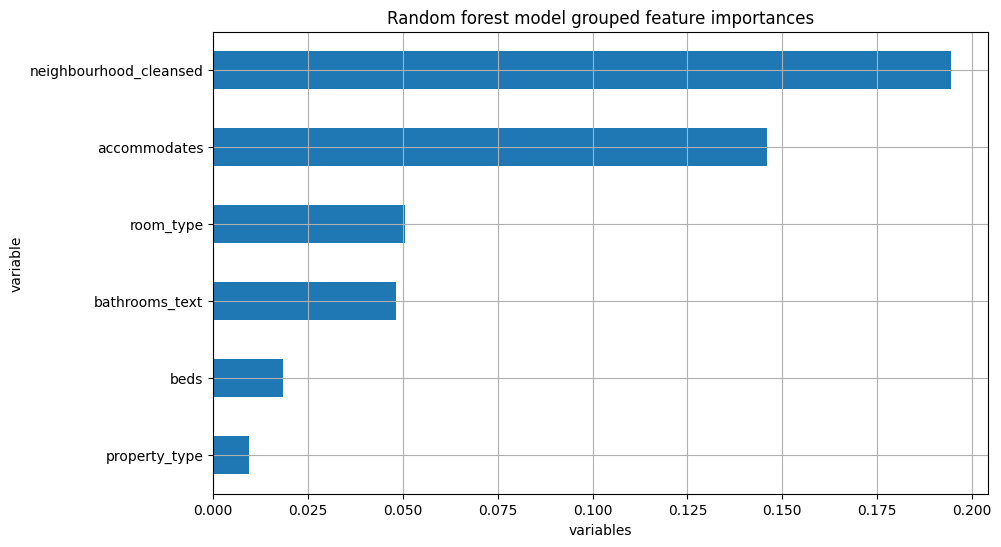

In [257]:
df_grouped_var_imp\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model grouped feature importances', 
          xlabel = 'variables', legend = False
         );

In [258]:
df_clean_varimp = pd.DataFrame(
        result.importances_mean,
        data_train[predictors_2].columns)\
    .sort_values(by = 0, ascending = False)\
    .reset_index()\
    .rename({'index': 'variable', 0: 'imp'}, axis = 1)

df_clean_varimp['cumulative_imp'] = df_var_imp['imp'].cumsum()
df_clean_varimp[df_clean_varimp.cumulative_imp < 0.91]

,variable,imp,cumulative_imp
0,neighbourhood_cleansed,0.194533,0.189582
1,accommodates,0.145854,0.349602
2,room_type,0.050602,0.448526
3,bathrooms_text,0.048252,0.535593
4,number_of_reviews,0.042814,0.600258
5,instant_bookable,0.032276,0.653134
6,review_scores_rating,0.027590,0.686117
7,beds,0.018293,0.715390
8,host_is_superhost,0.016887,0.743651
9,property_type,0.009523,0.770798


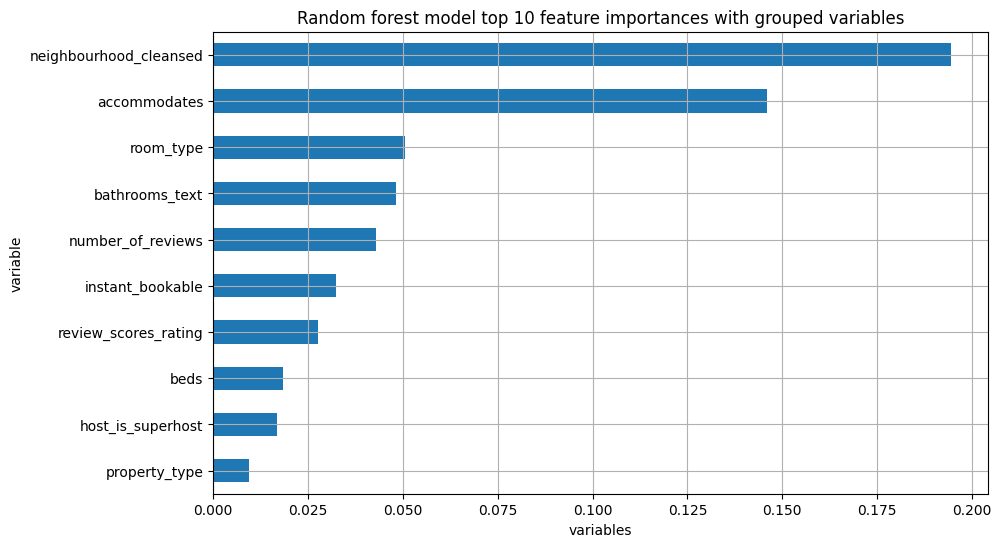

In [259]:
df_clean_varimp.iloc[0:10]\
    .sort_values(by = 'imp')\
    .plot(kind = 'barh', 
          x = 'variable', y = 'imp', 
          figsize = (10,6), grid = True, 
          title = 'Random forest model top 10 feature importances with grouped variables', 
          xlabel = 'variables', legend = False
         );

In [260]:
accomodates_pdp = partial_dependence(
    rf_pipeline, data_holdout[predictors_2], ["accommodates"], kind="average"
)

accomodates_pdp

{'grid_values': [array([2, 3, 4, 5, 6], dtype=int64)],
 'values': [array([2, 3, 4, 5, 6], dtype=int64)],
 'average': array([[ 92.37730636,  95.38469893, 106.72448103, 117.62097199,
         126.76392446]])}

In [261]:
pd.DataFrame(
    {'number of accomodates': accomodates_pdp['values'][0], 
     'average price': accomodates_pdp['average'][0]}
    )

,number of accomodates,average price
0,2,92.377306
1,3,95.384699
2,4,106.724481
3,5,117.620972
4,6,126.763924


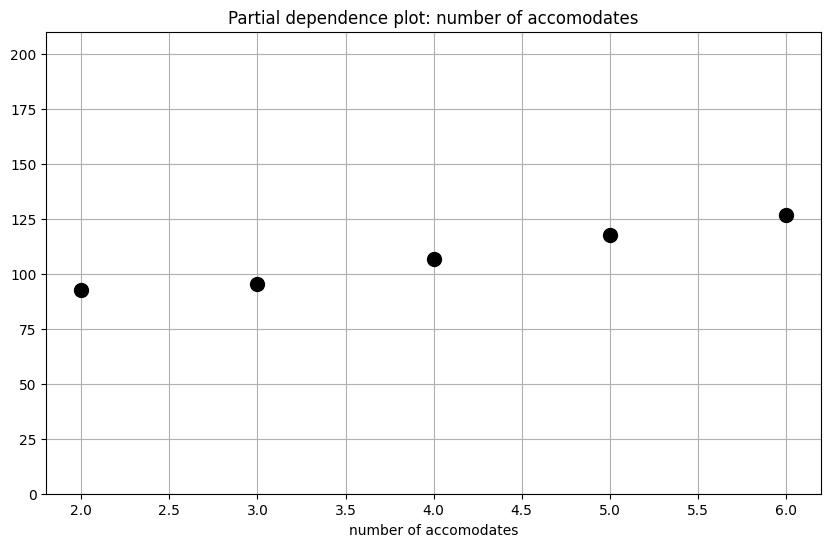

In [262]:
pd.DataFrame(
    {'number of accomodates': accomodates_pdp['values'][0], 
     'average price': accomodates_pdp['average'][0]}
    ).sort_values(by = 'average price').plot(
    kind = 'line', color = 'k', marker = 'o', markersize = 10, linewidth = 0,
    figsize = (10,6), legend = False, grid = True,
    x = 'number of accomodates', y = 'average price', ylim = (0, 210), 
    title = 'Partial dependence plot: number of accomodates'
);

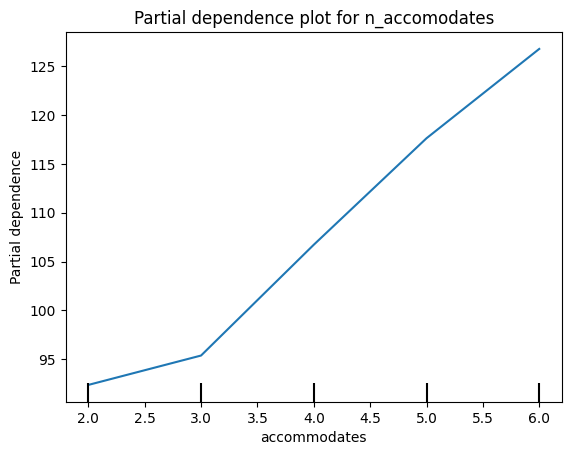

In [263]:
display = PartialDependenceDisplay(
    pd_results = [accomodates_pdp],
    features = [(0,)], 
    feature_names = data_holdout[predictors_2].columns.tolist(), 
    target_idx = 0,
    deciles = {0: np.linspace(2, 6, num=5)}
)
display.plot()
plt.title('Partial dependence plot for n_accomodates')
plt.show();

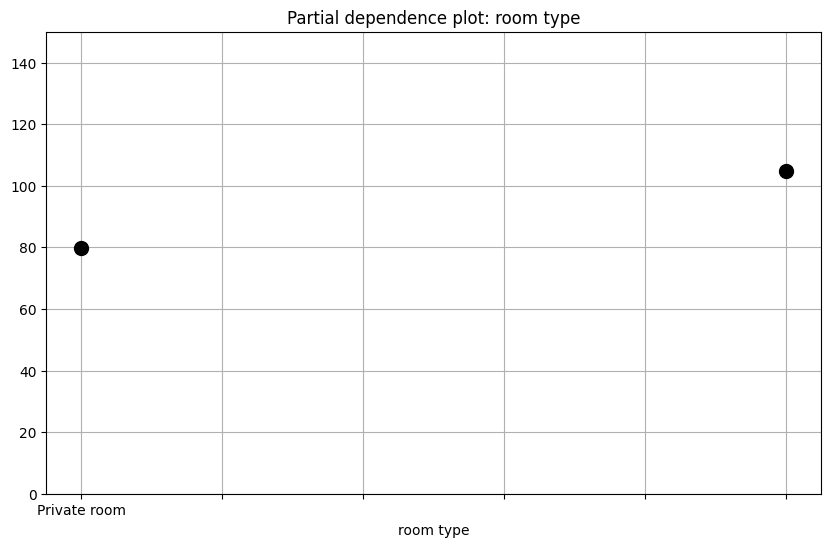

In [264]:
roomtype_pdp = partial_dependence(
    rf_pipeline, data_holdout[predictors_2], ["room_type"], kind="average"
)

pd.DataFrame(
    {'room type': roomtype_pdp['values'][0], 
     'average price': roomtype_pdp['average'][0]}
    ).sort_values(by = 'average price').plot(
    kind = 'line', color = 'k', marker = 'o', markersize = 10, linewidth = 0,
    figsize = (10,6), legend = False, grid = True,
    x = 'room type', y = 'average price', ylim = (0, 150), 
    title = 'Partial dependence plot: room type'
);

## Subsample Performance

In [265]:
data_holdout_w_prediction = data_holdout.assign(
    predicted_price=rf_pipeline.predict(data_holdout[predictors_2])
)

### Apartment Size

In [266]:
data_holdout_w_prediction['is_low_size'] = data_holdout_w_prediction.accommodates.map(lambda x: 'small apt' if x < 3 else 'large apt')

data_holdout_w_prediction.iloc[0:5, -5:]

,reviews_per_month,flag_number_of_reviews,flag_review_scores_rating,predicted_price,is_low_size
918,2.83,1,1,84.454507,small apt
12270,3.51,1,1,112.856538,large apt
6498,0.69,1,1,101.717734,large apt
12657,4.43,1,1,117.822771,large apt
5580,0.04,1,1,127.789886,large apt


In [267]:
data_holdout_w_prediction.groupby('is_low_size').apply(lambda x: mean_squared_error(x.predicted_price, x.price, squared=False))

is_low_size
large apt    42.154389
small apt    33.255789
dtype: float64

In [268]:
def calculate_rmse(groupby_obj):
    return (
        groupby_obj.apply(
            lambda x: mean_squared_error(x.predicted_price, x.price, squared=False),
        )
        .to_frame(name="rmse")
        .assign(mean_price=groupby_obj.apply(lambda x: np.mean(x.price)).values)
        .assign(rmse_norm=lambda x: x.rmse / x.mean_price).round(2)
    )


# cheaper or more expensive flats - not used in book
grouped_object = data_holdout_w_prediction.assign(
    is_low_size=lambda x: np.where(x.accommodates <= 3, "small apt", "large apt")
).groupby("is_low_size")
accom_subset = calculate_rmse(grouped_object)

accom_subset

,rmse,mean_price,rmse_norm
is_low_size,,,
large apt,44.16,119.71,0.37
small apt,33.53,85.83,0.39


### Fancy Neighbourhoods

In [269]:
grouped_object = data_holdout_w_prediction.loc[
    lambda x: x.neighbourhood_cleansed.isin(
        [
            "Innere Stadt",
            "Leopoldstadt",
            "Wieden",
            "Landstra§e",
        ]
    )
].groupby("neighbourhood_cleansed")
neightbourhood_subset = calculate_rmse(grouped_object)

neightbourhood_subset

,rmse,mean_price,rmse_norm
neighbourhood_cleansed,,,
Innere Stadt,53.22,171.36,0.31
Landstra§e,47.54,113.24,0.42
Leopoldstadt,35.95,101.93,0.35
Wieden,43.40,114.40,0.38


### Property Type

In [270]:
grouped_object = data_holdout_w_prediction.loc[
    lambda x: x.property_type.isin(["Entire rental unit", "Private room in rental unit", "Entire condo", "Private room in condo"])
].groupby("property_type")
proptype_subset = calculate_rmse(grouped_object)

proptype_subset

,rmse,mean_price,rmse_norm
property_type,,,
Entire condo,43.52,97.87,0.44
Entire rental unit,39.43,107.62,0.37
Private room in condo,35.32,65.32,0.54
Private room in rental unit,29.54,63.50,0.47


In [271]:
all_holdout = pd.DataFrame(
    [
        mean_squared_error(
            data_holdout_w_prediction.price,
            data_holdout_w_prediction.predicted_price,
            squared=False,
        ),
        data_holdout_w_prediction.price.mean(),
    ],
    index=["rmse", "mean_price"],
).T.assign(rmse_norm=lambda x: x.rmse / x.mean_price).round(2)
all_holdout.index = ["Total"]

all_holdout

,rmse,mean_price,rmse_norm
Total,39.06,102.31,0.38


### Performance

In [272]:
type_rows = pd.DataFrame(
    None,
    index=["Apartment size", "Type", "Borough", "------"],
    columns=["rmse", "mean_price", "rmse_norm"],
).fillna("------")

type_rows

,rmse,mean_price,rmse_norm
Apartment size,------,------,------
Type,------,------,------
Borough,------,------,------
------,------,------,------


In [273]:
pd.concat(
    [
        type_rows.iloc[[0]],
        accom_subset,
        type_rows.iloc[[1]],
        proptype_subset,
        type_rows.iloc[[2]],
        neightbourhood_subset,
        type_rows.iloc[[3]],
        all_holdout,
    ]
)

,rmse,mean_price,rmse_norm
Apartment size,------,------,------
large apt,44.16,119.71,0.37
small apt,33.53,85.83,0.39
Type,------,------,------
Entire condo,43.52,97.87,0.44
Entire rental unit,39.43,107.62,0.37
Private room in condo,35.32,65.32,0.54
Private room in rental unit,29.54,63.5,0.47
Borough,------,------,------
Innere Stadt,53.22,171.36,0.31


# LASSO

In [274]:
lasso_model =  ElasticNet(l1_ratio = 1, fit_intercept = True)

lasso_model_cv = GridSearchCV(
    lasso_model,
    # {"alpha":[i/100 for i in range(1, 26, 1)]}, > this option takes forever to run
    {"alpha":[i/100 for i in range(5, 26, 5)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

y, X = dmatrices("price ~ " + " + ".join(predictors_E), data_train)

In [275]:
%%time
lasso_model_cv.fit(X, y.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ......................alpha=0.05;, score=-42.146 total time=   0.0s


[CV 2/5] END ......................alpha=0.05;, score=-44.810 total time=   0.1s
[CV 3/5] END ......................alpha=0.05;, score=-40.144 total time=   0.0s
[CV 4/5] END ......................alpha=0.05;, score=-39.951 total time=   0.0s
[CV 5/5] END ......................alpha=0.05;, score=-42.936 total time=   0.0s
[CV 1/5] END .......................alpha=0.1;, score=-42.268 total time=   0.0s
[CV 2/5] END .......................alpha=0.1;, score=-44.792 total time=   0.0s
[CV 3/5] END .......................alpha=0.1;, score=-40.288 total time=   0.0s
[CV 4/5] END .......................alpha=0.1;, score=-40.245 total time=   0.0s
[CV 5/5] END .......................alpha=0.1;, score=-43.078 total time=   0.0s
[CV 1/5] END ......................alpha=0.15;, score=-42.332 total time=   0.0s
[CV 2/5] END ......................alpha=0.15;, score=-44.827 total time=   0.0s
[CV 3/5] END ......................alpha=0.15;, score=-40.423 total time=   0.0s
[CV 4/5] END ...............

GridSearchCV(cv=5, estimator=ElasticNet(l1_ratio=1),
             param_grid={'alpha': [0.05, 0.1, 0.15, 0.2, 0.25]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [276]:
pd.DataFrame(
    lasso_model_cv.best_estimator_.coef_.tolist(),
    index=X.design_info.column_names,
    columns=["lasso_coefficient"],
).assign(lasso_coefficient=lambda x: x.lasso_coefficient.round(3)).loc[
    lambda x: x.lasso_coefficient != 0
]

,lasso_coefficient
property_type[T.Entire rental unit],4.260
room_type[T.Private room],-31.485
bathrooms_text[T.1 bath],-7.880
bathrooms_text[T.1 private bath],24.154
bathrooms_text[T.1 shared bath],-2.201
...,...
host_is_superhost,8.521
host_has_profile_pic,5.211
host_identity_verified,2.488
instant_bookable,8.973


In [277]:
lasso_model_cv.best_estimator_

ElasticNet(alpha=0.05, l1_ratio=1)

In [278]:
lasso_model_cv.cv_results_

{'mean_fit_time': array([0.1211885 , 0.04166551, 0.0416894 , 0.04228611, 0.03611121]),
 'std_fit_time': array([0.04302613, 0.00262558, 0.00114213, 0.00305013, 0.00788497]),
 'mean_score_time': array([0.00138707, 0.00101013, 0.00111136, 0.00119433, 0.00148306]),
 'std_score_time': array([5.00795019e-04, 1.74208134e-05, 2.27677964e-04, 4.00467440e-04,
        6.14504184e-04]),
 'param_alpha': masked_array(data=[0.05, 0.1, 0.15, 0.2, 0.25],
              mask=[False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.05},
  {'alpha': 0.1},
  {'alpha': 0.15},
  {'alpha': 0.2},
  {'alpha': 0.25}],
 'split0_test_score': array([-42.1459197 , -42.2682889 , -42.33167484, -42.40231097,
        -42.48516534]),
 'split1_test_score': array([-44.8096518 , -44.79246852, -44.82748663, -44.89725329,
        -45.00142466]),
 'split2_test_score': array([-40.1441484 , -40.28783473, -40.42285101, -40.56990086,
        -40.68493058]),
 'split3_test_score

In [279]:
lasso_rmse = pd.DataFrame(lasso_model_cv.cv_results_).loc[
    lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha
].mean_test_score.values[0] * -1
lasso_rmse

41.997241301111174

# Comparing

In [280]:
pd.DataFrame({'model': ['OLS', 'Random Forest', 'LASSO'],
              'CV RMSE': [ols_rmse, all_holdout.rmse[0], lasso_rmse]})

,model,CV RMSE
0,OLS,41.727361
1,Random Forest,39.060000
2,LASSO,41.997241
